# EDA Goals

- To find which factors that have highest and lowest correlation value to house price
- To create a model that could predict house price

# Import Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateparser


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u


# Splitting data into training/testing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Cross Validation
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

#ML Modelling
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#Display Setting
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
df = pd.read_csv('kc_house_data.csv', index_col='id')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


# Data Cleaning

In [3]:
## Checking Data

In [4]:
houseDesc = []

for i in df.columns:
    houseDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        (((df[i].isna().sum()) / len(df)) * 100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [5]:
pd.DataFrame(data = houseDesc, columns= [
    'Data Feature',
    'Data Types',
    'Null',
    'Null Pct',
    'Unique',
    'Unique Sample'
] )

,Data Feature,Data Types,Null,Null Pct,Unique,Unique Sample
0,date,object,0,0.00,372,"[20150211T000000, 20150108T000000]"
1,price,float64,0,0.00,4028,"[222900.0, 1457000.0]"
2,bedrooms,int64,0,0.00,13,"[5, 8]"
3,bathrooms,float64,0,0.00,30,"[2.0, 3.0]"
4,sqft_living,int64,0,0.00,1038,"[1240, 2005]"
5,sqft_lot,int64,0,0.00,9782,"[5962, 196020]"
6,floors,float64,0,0.00,6,"[2.0, 1.0]"
7,waterfront,int64,0,0.00,2,"[0, 1]"
8,view,int64,0,0.00,5,"[0, 1]"
9,condition,int64,0,0.00,5,"[2, 4]"


In [6]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
#change date columns into year
df['date'] = df['date'].replace('T000000', '')

In [8]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
purchase_dt = df['date'].dt
df['year'] = purchase_dt.year

In [9]:
#create new column to show house age
df['house_age'] = df['year'] - df['yr_built']

In [10]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,house_age
id,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,2014,59
6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639,2014,63
5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062,2015,82
2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000,2014,49
1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503,2015,28


#### Drop not useable column

In [11]:
#drop date, year, yr_built because it's represented by house age
#drop yr_renovated because it's not described how different the house after renovated compared when the house was built
#drop long and lat because it's redundant with zipcode

In [12]:
df_filtered = df.drop(['date', 'yr_renovated', 'long', 'lat', 'year', 'yr_built'], axis = 1)

#### Check for outliers

In [13]:
df_filtered.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'house_age'],
      dtype='object')

In [14]:
# Select columns to plot

cols_to_plot = df_filtered[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 
                           'house_age']]

Graph for price: Total = 4028


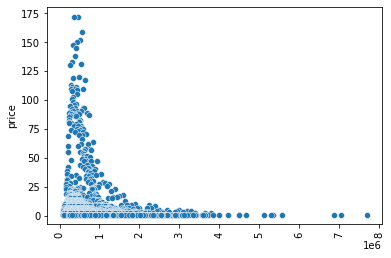

Graph for bedrooms: Total = 13


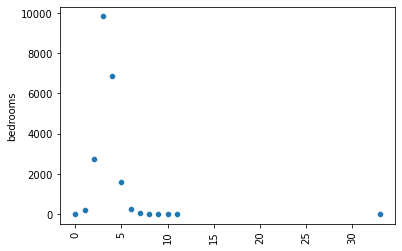

Graph for bathrooms: Total = 30


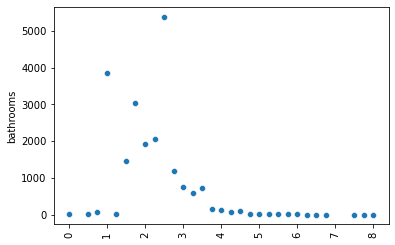

Graph for sqft_living: Total = 1038


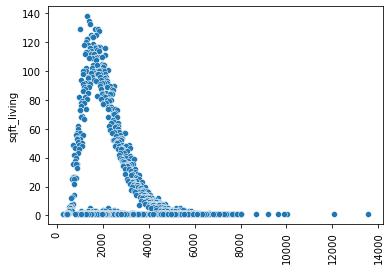

Graph for sqft_lot: Total = 9782


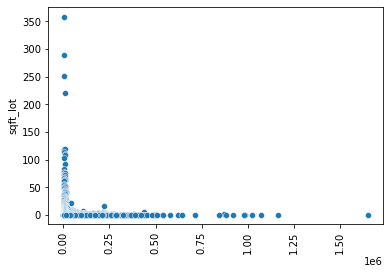

Graph for floors: Total = 6


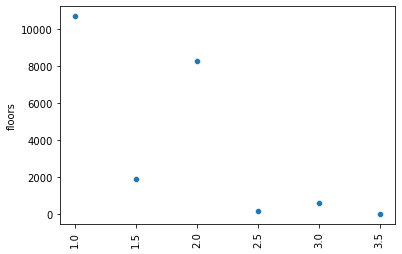

Graph for waterfront: Total = 2


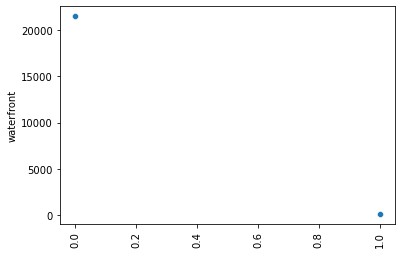

Graph for view: Total = 5


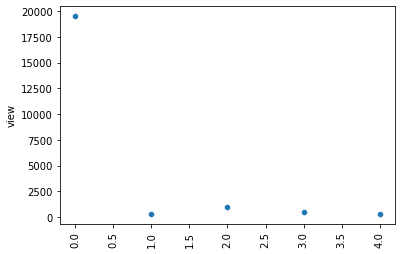

Graph for condition: Total = 5


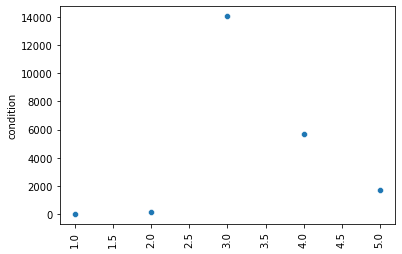

Graph for grade: Total = 12


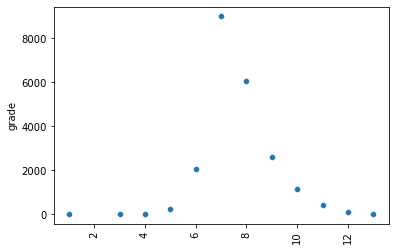

Graph for sqft_above: Total = 946


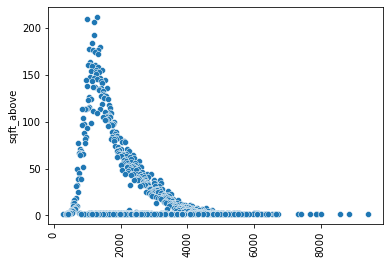

Graph for sqft_basement: Total = 306


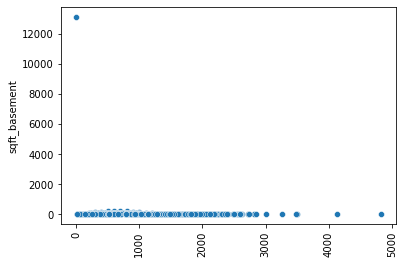

Graph for zipcode: Total = 70


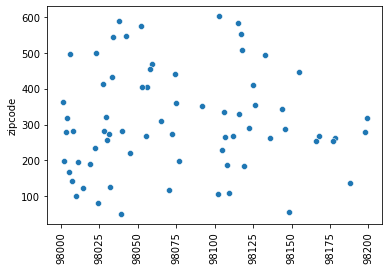

Graph for sqft_living15: Total = 777


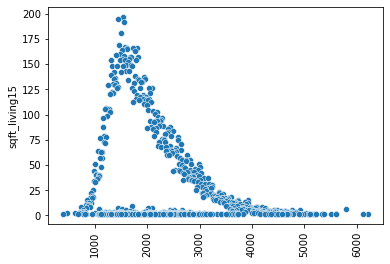

Graph for sqft_lot15: Total = 8689


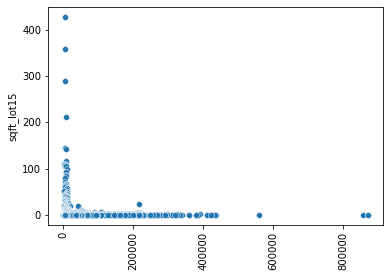

Graph for house_age: Total = 117


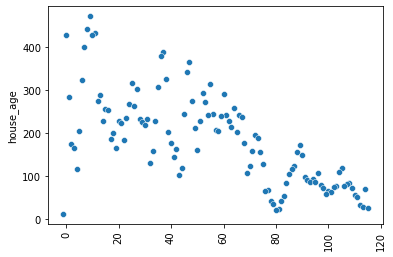

In [15]:
def plot_scatterplots():
    for i in cols_to_plot.columns:
        cat_num = cols_to_plot[i].value_counts()
        print(f'Graph for {i}: Total = {len(cat_num)}')
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
        
plot_scatterplots()

#### Initial thoughts on graphs above.

- price - Drop data from price >5 Million since it's too far from the others and only <10 datas.
- bedrooms - Drop data from bedrooms >30 since it's too far from the others and only <10 data.
<!-- bedroom and bathroom - 0? -->
- sqft_living - Drop data from >8k since it's too far from the others and only <10 datas.
- sqft_lot - Drop data from >750k since it's too far from the others and only <10 datas.
- sqft_above - Drop data from >7k since it's too far from the others and only <10 datas.
- sqft_basement - Drop data from >3k since it's too far from the others and only <10 datas.
- sqft_lot15 - Drop data from >500k since it's too far from the others and only <10 datas.

In [16]:
df_clean = df_filtered

In [17]:
#Price
df_clean = df_clean[df_clean.price < 5000000]

In [18]:
#Bedrooms
df_clean = df_clean[df_clean.bedrooms < 30]

In [19]:
#Bedrooms
df_clean = df_clean[df_clean.bedrooms < 30]

In [20]:
#sqft_living
df_clean = df_clean[df_clean.sqft_living < 8000]

In [21]:
#sqft_lot
df_clean = df_clean[df_clean.sqft_lot < 750000]

In [22]:
#sqft_above
df_clean = df_clean[df_clean.sqft_above < 7000]

In [23]:
#sqft_basement
df_clean = df_clean[df_clean.sqft_basement < 3000]

In [24]:
#sqft_lot15
df_clean = df_clean[df_clean.sqft_lot15 < 500000]

In [25]:
df_clean

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,house_age
id,,,,,,,,,,,,,,,,
7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,98178,1340,5650,59
6414100192,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,98125,1690,7639,63
5631500400,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,98028,2720,8062,82
2487200875,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,98136,1360,5000,49
1954400510,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,98074,1800,7503,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.00,3,2.50,1530,1131,3.00,0,0,3,8,1530,0,98103,1530,1509,5
6600060120,400000.00,4,2.50,2310,5813,2.00,0,0,3,8,2310,0,98146,1830,7200,1
1523300141,402101.00,2,0.75,1020,1350,2.00,0,0,3,7,1020,0,98144,1020,2007,5


29 datas have been dropped

Graph for price: Total = 4015


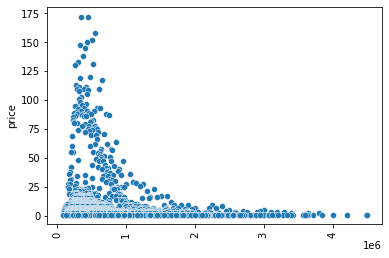

Graph for bedrooms: Total = 12


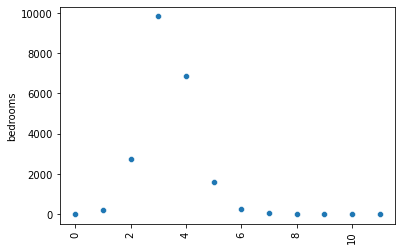

Graph for bathrooms: Total = 27


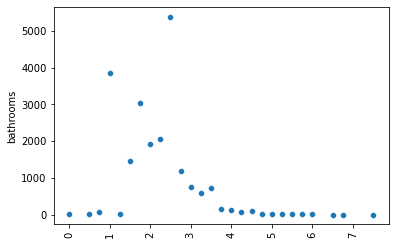

Graph for sqft_living: Total = 1019


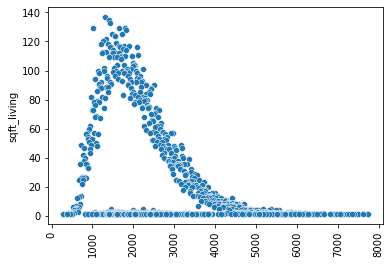

Graph for sqft_lot: Total = 9758


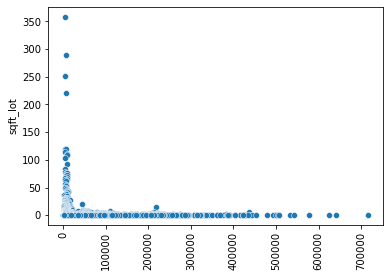

Graph for floors: Total = 6


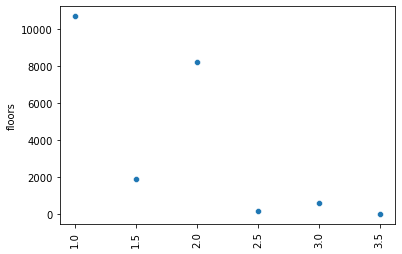

Graph for waterfront: Total = 2


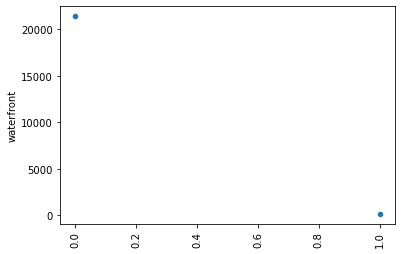

Graph for view: Total = 5


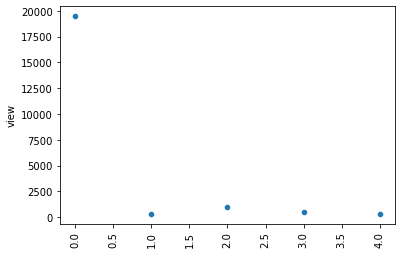

Graph for condition: Total = 5


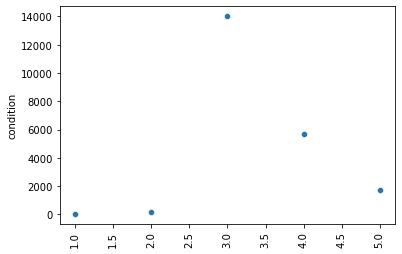

Graph for grade: Total = 12


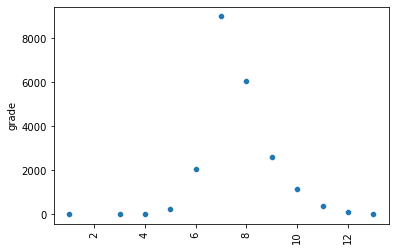

Graph for sqft_above: Total = 932


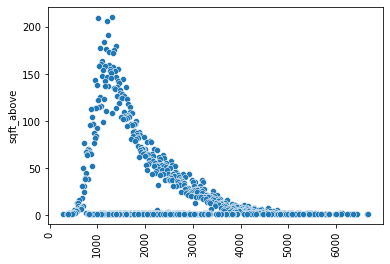

Graph for sqft_basement: Total = 298


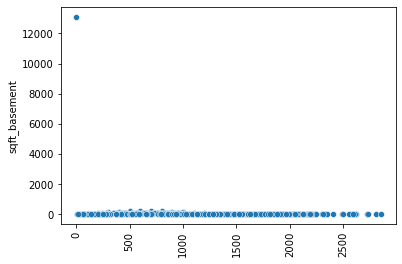

Graph for zipcode: Total = 70


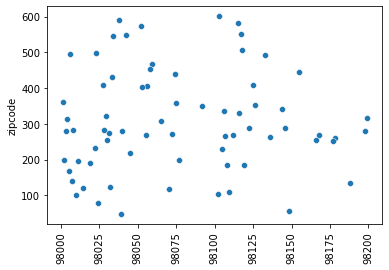

Graph for sqft_living15: Total = 774


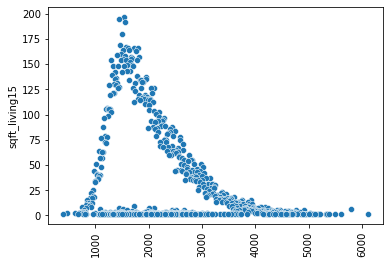

Graph for sqft_lot15: Total = 8672


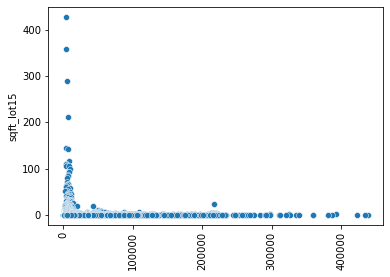

Graph for house_age: Total = 117


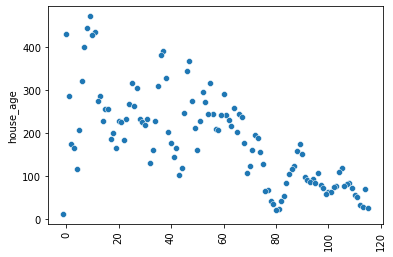

In [26]:
#check graphics after cleaning

cols_to_plot_new = df_clean[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'house_age']]
def plot_scatterplots_new():
    for i in cols_to_plot_new.columns:
        cat_num = cols_to_plot_new[i].value_counts()
        print(f'Graph for {i}: Total = {len(cat_num)}')
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
        
plot_scatterplots_new()

# Data Analysis

In [27]:
df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,house_age
count,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00,21583.00
mean,537055.53,3.37,2.11,2073.91,14531.10,1.49,0.01,0.23,3.41,7.65,1783.73,290.18,98077.98,1984.70,12575.93,43.33
std,349005.77,0.91,0.76,897.16,34037.43,0.54,0.09,0.76,0.65,1.17,814.01,437.90,53.51,682.35,25347.89,29.37
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,98001.00,399.00,651.00,-1.00
25%,321000.00,3.00,1.75,1420.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,98033.00,1490.00,5100.00,18.00
50%,450000.00,3.00,2.25,1910.00,7610.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,98065.00,1840.00,7620.00,40.00
75%,643000.00,4.00,2.50,2550.00,10650.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,98118.00,2360.00,10078.00,63.00
max,4500000.00,11.00,7.50,7730.00,715690.00,3.50,1.00,4.00,5.00,13.00,6660.00,2850.00,98199.00,6110.00,438213.00,115.00


In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21583 entries, 7129300520 to 1523300157
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21583 non-null  float64
 1   bedrooms       21583 non-null  int64  
 2   bathrooms      21583 non-null  float64
 3   sqft_living    21583 non-null  int64  
 4   sqft_lot       21583 non-null  int64  
 5   floors         21583 non-null  float64
 6   waterfront     21583 non-null  int64  
 7   view           21583 non-null  int64  
 8   condition      21583 non-null  int64  
 9   grade          21583 non-null  int64  
 10  sqft_above     21583 non-null  int64  
 11  sqft_basement  21583 non-null  int64  
 12  zipcode        21583 non-null  int64  
 13  sqft_living15  21583 non-null  int64  
 14  sqft_lot15     21583 non-null  int64  
 15  house_age      21583 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.8 MB


## Hypothesis
- number of bedrooms has an effect on the price
- number of bathrooms has an effect on the price
- number of floors has an effect on the price
- grade has an effect on the price
- condition has an effect on the price
- yr_built has an effect on the price
- zipcode has an effect on the price

In [29]:
df_clean.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,house_age
price,1.00,0.32,0.52,0.69,0.09,0.26,0.25,0.39,0.04,0.67,0.60,0.31,-0.05,0.59,0.07,-0.05
bedrooms,0.32,1.00,0.53,0.59,0.04,0.18,-0.01,0.08,0.03,0.36,0.49,0.31,-0.16,0.40,0.03,-0.16
bathrooms,0.52,0.53,1.00,0.75,0.09,0.50,0.05,0.18,-0.13,0.66,0.68,0.27,-0.20,0.57,0.08,-0.51
sqft_living,0.69,0.59,0.75,1.00,0.18,0.36,0.09,0.27,-0.06,0.76,0.87,0.43,-0.20,0.76,0.18,-0.32
sqft_lot,0.09,0.04,0.09,0.18,1.00,-0.01,0.03,0.07,-0.01,0.12,0.19,0.02,-0.14,0.17,0.77,-0.06
floors,0.26,0.18,0.50,0.36,-0.01,1.00,0.02,0.03,-0.26,0.46,0.53,-0.25,-0.06,0.28,-0.02,-0.49
waterfront,0.25,-0.01,0.05,0.09,0.03,0.02,1.00,0.40,0.02,0.08,0.06,0.07,0.03,0.08,0.03,0.03
view,0.39,0.08,0.18,0.27,0.07,0.03,0.40,1.00,0.05,0.24,0.16,0.27,0.09,0.28,0.06,0.06
condition,0.04,0.03,-0.13,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.18,0.00,-0.09,-0.00,0.36
grade,0.67,0.36,0.66,0.76,0.12,0.46,0.08,0.24,-0.14,1.00,0.75,0.16,-0.18,0.71,0.11,-0.45


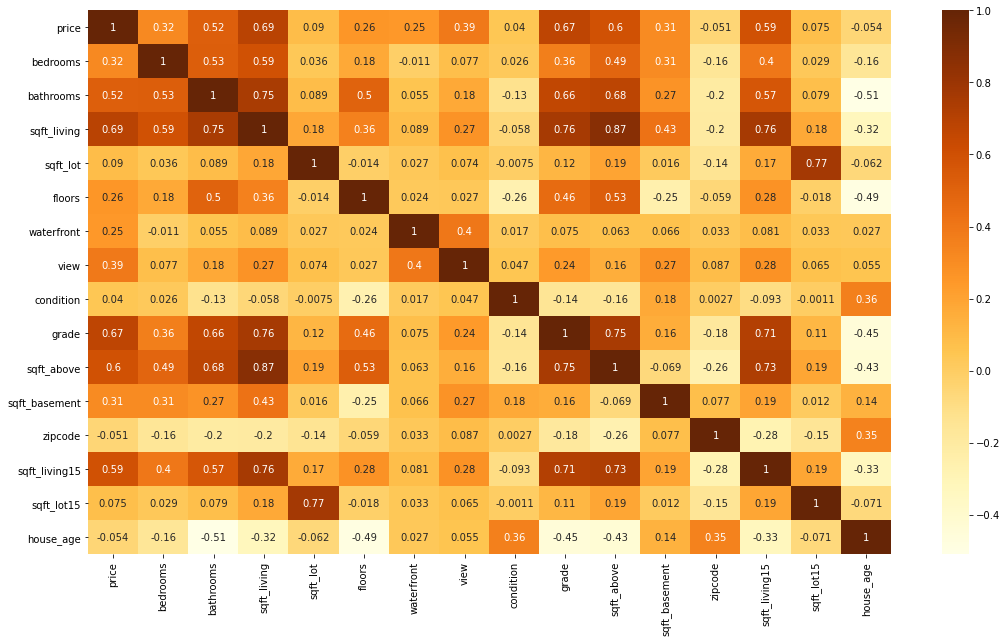

In [30]:
plt.figure(figsize=(18,10))
sns.heatmap(df_clean.corr(), cmap='YlOrBr', annot=True)
plt.show()

- sqft_living, grade, sqft_above have the highest correlation value to the price (0.69, 0.67, 0.60 respectively)

- condition, zipcode, house age have the lowest correlation value to the price (0.04, -0.051, 0.054 respectively)

## Highest correlation value factors

### sqft_living

In [31]:
#Binning sqft_living column

In [32]:
df_clean['sqft_living'].max()

7730

In [33]:
df_clean['sqft_living'].min()

290

In [34]:
sqft_living_bin = [0, 3500, 7000, df_clean['sqft_living'].max()] ## create sqft_living groups

In [35]:
labels = ['Small', 'Medium', 'Large'] ## Label for sqft_living groups

In [36]:
df_clean['sqft_living_bin'] = pd.cut(df_clean['sqft_living'], bins=sqft_living_bin, labels=labels)

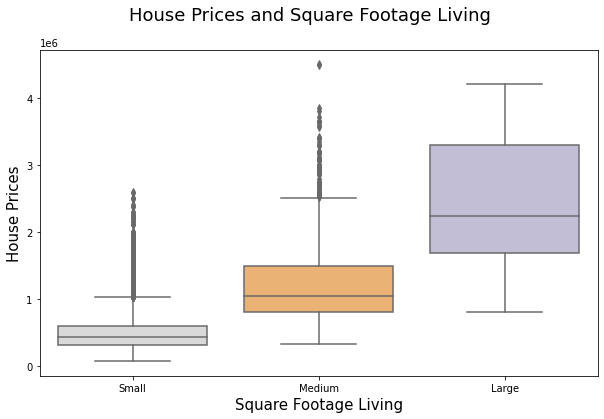

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df_clean['sqft_living_bin'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and Square Footage Living', size=18)
plt.xlabel('Square Footage Living', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

Lots of outliers for apartment/house that have between small and medium size of interior living space

Significant increase in the price range as the size increases.


### House Grade

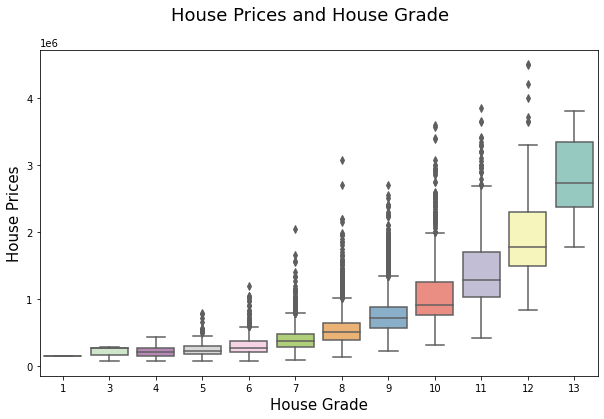

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df_clean['grade'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and House Grade', size=18)
plt.xlabel('House Grade', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

Lots of outliers for apartment/house that have between 5-12 of house grades

Significant increase in the price range as the grade increases.

### sqft_above

In [39]:
df_clean['sqft_above'].max()

6660

In [40]:
df_clean['sqft_above'].min()

290

In [41]:
#Binning sqft_above column

In [42]:
sqft_above_bin = [0, 3000, 6000, df_clean['sqft_above'].max()] ## create sqft_above groups

In [43]:
df_clean['sqft_above_bin'] = pd.cut(df_clean['sqft_above'], bins=sqft_above_bin, labels=labels)

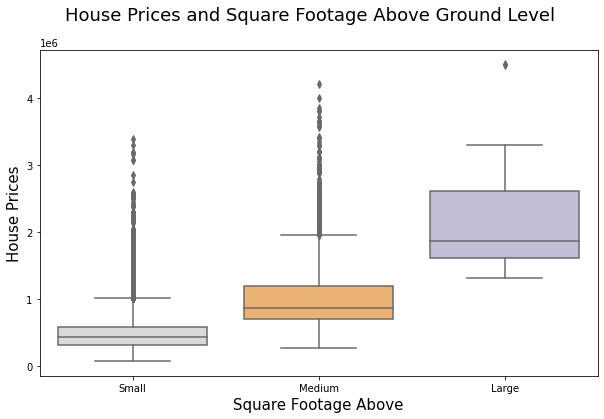

In [44]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df_clean['sqft_above_bin'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and Square Footage Above Ground Level', size=18)
plt.xlabel('Square Footage Above', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

Lots of outliers for apartment/house that have between small and medium size of interior living space

Significant increase in the price range as the size increases.


## Lowest correlation value factors

### Condition 

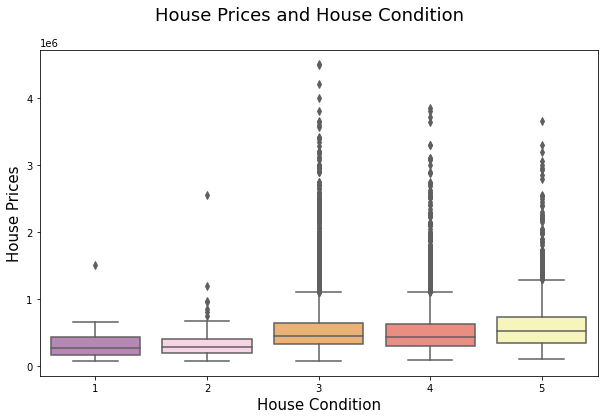

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df_clean['condition'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and House Condition', size=18)
plt.xlabel('House Condition', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

Lots of outliers for apartment/house that have between 3-5 

Highest price lied in house condition level 3, however if we exclude the outliers, condition number 5 has the highest price.

## House Age

In [46]:
#binning house age

In [47]:
df['house_age'].unique()

array([ 59,  63,  82,  49,  28,  13,  19,  52,  55,  12,  50,  72,  87,
        37, 115,  36,  20,  98,  93,  46,  67,  29,  73,  99, 105,  66,
        10,  11,   9,  85,  33,  84,  81, 110,  18,  14,  30,   0,  92,
        62,  64,  34,  88,   6,  24,  60,  41,  35,  89,  25,  43,  58,
        74,  22,  51,  53,   8,  26,  75,  68,  48,  39, 104,  31, 114,
         4,  69,  65,  90,  27, 101,  47,  54, 109,   7,  61,  15,  38,
        16, 113,  21,  94,  45, 100, 111,  96,  97,  86, 103,  78,  77,
        76, 107,  40,  57, 102,  17,  71,   1,  23,  91,  42,  95,   2,
        32,   3,  56,  70,  44, 112,   5,  80,  83, 106, 108,  79,  -1],
      dtype=int64)

In [48]:
df['house_age'].max()

115

In [49]:
house_age_bin = [0, 20, 40,60,80,100, df_clean['sqft_above'].max()] ## create sqft_above groups

In [50]:
df_clean['sqft_above_bin'] = pd.cut(df_clean['sqft_above'], bins=sqft_above_bin, labels=labels)

In [51]:
labels_age = ['<20', '>20', '>40', '>60', '>80', '>100']

In [52]:
df_clean['house_age_bin'] = pd.cut(df_clean['house_age'], bins=house_age_bin, labels=labels_age)

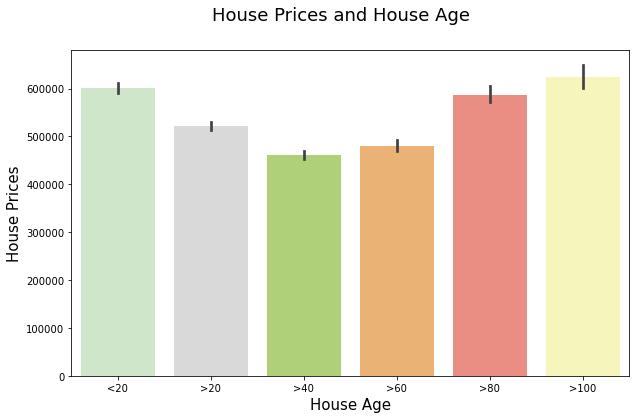

In [53]:
plt.figure(figsize=(10,6))
sns.barplot(x = df_clean['house_age_bin'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and House Age', size=18)
plt.xlabel('House Age', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)

plt.show()

- Houses age <20 and after >60 also +100 have a higher average price.
- Houses age >20 and <80 cost less on average.
- It shows that people interested in new houses or a antique houses indeed

### zipcode

In [54]:
df_clean['zipcode'].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039], dtype=int64)

In [55]:
# Create a dataframe for the top 5/bottom 5 zipcodes in terms of average price. Then, combine the dataframes. 

top = df_clean.groupby('zipcode')['price'].mean().reset_index().sort_values('price', ascending=False)[:5]
bot = df_clean.groupby('zipcode')['price'].mean().reset_index().sort_values('price', ascending=False)[-5:]
combined = pd.concat([top, bot])
combined.sort_values('price', ascending=True, inplace=True)

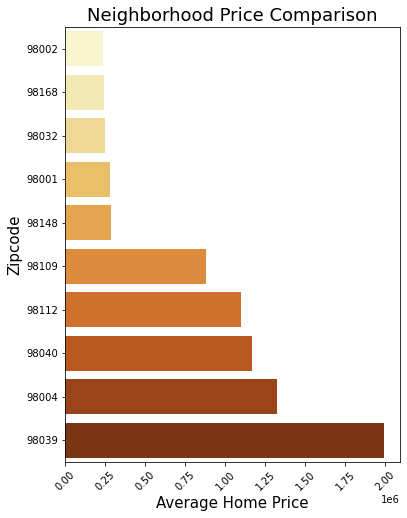

In [56]:
plt.figure(figsize=(6,8))

sns.barplot(x='price', y='zipcode' , order = combined['zipcode'], orient='h', data=combined, palette='YlOrBr')

plt.title('Neighborhood Price Comparison', size=18)
plt.ylabel('Zipcode', size=15)
plt.xlabel('Average Home Price', size=15)
plt.xticks(rotation=45)

plt.show()

From the graph above, it shows that the location of the house has an effect to house price

### Hypothesis Testing

### Bedrooms

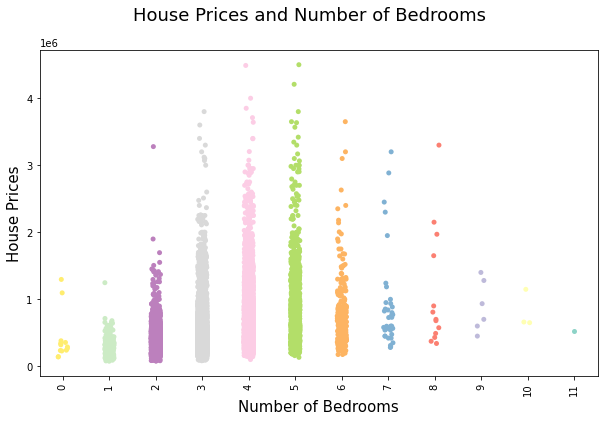

In [60]:
plt.figure(figsize=(10,6))
sns.stripplot(x = df_clean['bedrooms'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and Number of Bedrooms', size=18)
plt.xlabel('Number of Bedrooms', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)
plt.xticks(rotation=90)

plt.show()

- lots of outliers from number of bedrooms 2 - 7
- there's increasing trend of price along with number of bedrooms until number of bedroom 5, but after it it's just decreasing along with the increase of number of bedrooms

### Bathrooms

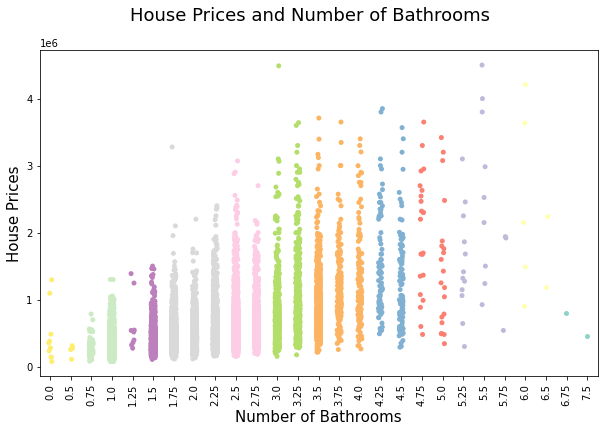

In [61]:
plt.figure(figsize=(10,6))
sns.stripplot(x = df_clean['bathrooms'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and Number of Bathrooms', size=18)
plt.xlabel('Number of Bathrooms', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)
plt.xticks(rotation=90)

plt.show()

- there's increasing trend of price along with number of bathrooms until number of bedroom 5, but after it it's just decreasing along with the increase of number of bedrooms
- most sold house/apartment are at 1.75 - 3.5 number of bathrooms

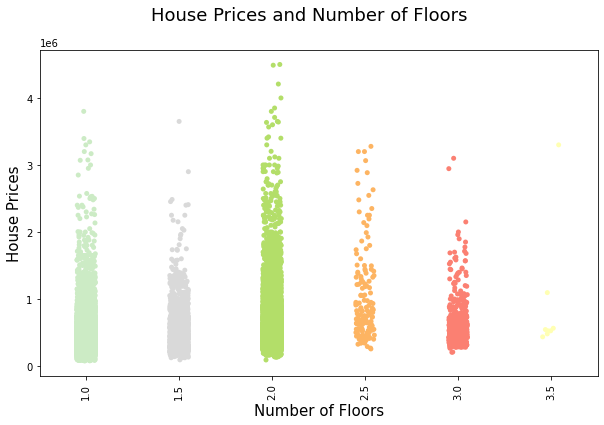

In [62]:
plt.figure(figsize=(10,6))
sns.stripplot(x = df_clean['floors'], y=df_clean['price'], palette="Set3_r")
plt.suptitle('House Prices and Number of Floors', size=18)
plt.xlabel('Number of Floors', fontsize = 15)
plt.ylabel('House Prices', fontsize = 15)
plt.xticks(rotation=90)

plt.show()

- there's increasing trend of price along with number of floors until number of floors 2.5, but after it it's just decreasing even at 3.5 floor it has more price than 3 floor
- most sold house/apartment are at 1 - 2 number of floors

# Data Insight

- size of the house (or sqft_living) has a positive impact to house price
- house grade has a positive impact to house price
- house condition not really has an impact to house price
- house age might be has an impact to house price, but not in linear relationship
- house location has an impact to house price
- number of bedrooms in the house has an positive impact to house price but only until bedroom number 5, after that it's just decreasing
- number of bathrooms in the house has an positive impact to house price but only until bedroom number 3.5, after that it's just decreasing
- number of floors in the house has an positive impact to house price but only until bedroom number 2, after that it's just decreasing


- also the dataset is full of outliers, it might distrupt the model and considered to be dropped in data modelling

In [63]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'house_age',
       'sqft_living_bin', 'sqft_above_bin', 'house_age_bin'],
      dtype='object')

# Modelling

In [93]:
X = df_clean.drop(['price', 'sqft_living_bin', 'sqft_above_bin', 'house_age_bin'], axis='columns')
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

## Base Model

In [130]:
# num_columns = ['enrollee_id','city_development_index', 'training_hours']
num_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'house_age']

cat_columns = ['waterfront', 'view', 'condition', 'grade', ]

# cat_scaling = ['smoking_status']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# numeric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
# ])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns),
])

pipeline_KNN = Pipeline([
    ("prep", preprocessor),
    ('algo', KNeighborsRegressor())
])
pipeline_RF =  Pipeline([
    ("prep", preprocessor),
    ('algo', RandomForestRegressor())
])

pipeline_DT= Pipeline([
    ("prep", preprocessor),
    ('algo', DecisionTreeRegressor())
])
pipeline_SVM = Pipeline([
    ("prep", preprocessor),
    ('algo', SVR())
])

pipeline_LR = Pipeline([
    ("prep", preprocessor),
    ('algo', LinearRegression())
])



In [131]:
def Eva_matrix(Model, X_train, y_train, X_test, y_test, Name):
    y_pred_tr = Model.predict(X_train)
    r2_tr = r2_score(y_train, y_pred_tr)
    mae_tr = mean_absolute_error(y_train, y_pred_tr)
    mse_tr = mean_squared_error(y_train, y_pred_tr)
    rmse_tr = np.sqrt(mse_tr)
    y_ts = Model.predict(X_test)
    r2_ts = r2_score(y_test, y_ts)
    mae_ts = mean_absolute_error(y_test, y_ts)
    mse_ts = mean_squared_error(y_test, y_ts)
    rmse_ts = np.sqrt(mse_ts)
    data = {
        f"Train {Name}" : [r2_tr, mae_tr, mse_tr, rmse_tr],
        f"Test {Name}" : [r2_ts, mae_ts, mse_ts, rmse_ts]
    }
    df = pd.DataFrame(data, index=['R2', 'MAE', 'MSE', 'RMSE'])
    return df

## LR Base Model

In [132]:
pipeline_LR.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [133]:
df_LR_base = Eva_matrix(pipeline_LR, X_train, y_train, X_test, y_test, "Base LR")
df_LR_base

,Train Base LR,Test Base LR
R2,0.68,0.65
MAE,131817.56,134606.15
MSE,39200431761.47,41246896077.15
RMSE,197990.99,203093.32


## KNN Base Model

In [134]:
pipeline_KNN.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [135]:
df_KNN_base = Eva_matrix(pipeline_KNN, X_train, y_train, X_test, y_test, "Base KNN")
df_KNN_base

,Train Base KNN,Test Base KNN
R2,0.80,0.68
MAE,97404.12,118964.82
MSE,24375204893.38,37212919706.30
RMSE,156125.61,192906.51


## SV Regression Base Model

In [136]:
pipeline_SVM.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [137]:
df_SVM_base = Eva_matrix(pipeline_SVM, X_train, y_train, X_test, y_test, "Base SVM")
df_SVM_base

,Train Base SVM,Test Base SVM
R2,-0.06,-0.06
MAE,218789.72,217287.42
MSE,130024981083.52,124592425113.41
RMSE,360589.77,352976.52


## Decision Tree Regression Base Model

In [138]:
pipeline_DT.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [139]:
df_DT_base = Eva_matrix(pipeline_DT, X_train, y_train, X_test, y_test, "Base XGB")
df_DT_base

,Train Base XGB,Test Base XGB
R2,1.00,0.63
MAE,185.49,119560.34
MSE,13452288.47,44041015691.99
RMSE,3667.74,209859.51


## Random Forest Base Model

In [140]:
pipeline_RF.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [141]:
df_RF_base = Eva_matrix(pipeline_RF, X_train, y_train ,X_test, y_test, "Base RF")
df_RF_base

,Train Base RF,Test Base RF
R2,0.97,0.80
MAE,32463.36,86142.06
MSE,3172900105.43,23052106669.62
RMSE,56328.50,151829.20


the best model between the models above is between KNN Regressor, Decision Tree, and Random Forest Regression, based on R2 score in Training on 0.97 and in Testing on 0.81 for Random Forest while DT Regressor is 1 on Training and 0.63 on Testing. But, all models show that they are overfit, so we have to tuning the parameters.

# Hyperparameter Tuning

## KNN Hyperparameter Tuning

In [79]:
param_KNN = {
    'algo__n_neighbors': np.arange(2,51,2),
    'algo__weights' : ['uniform', 'distance'],
    'algo__leaf_size' : np.arange(2,51,2),
    "algo__p" : [1,2],
}

In [80]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [81]:
KNN_RS= RandomizedSearchCV(pipeline_KNN, param_KNN, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='r2')

In [82]:
KNN_RS.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.1min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['bedrooms',
                                                                                'bathrooms',
                                                                                'sqft_living',
                                                 

In [83]:
KNN_RS.best_params_

{'algo__weights': 'distance',
 'algo__p': 1,
 'algo__n_neighbors': 6,
 'algo__leaf_size': 12}

In [84]:
KNN_HT = KNN_RS.best_estimator_

In [85]:
df_KNN_HT = Eva_matrix(KNN_HT, X_train, y_train, X_test, y_test, "KNN Tuned")
df_KNN_HT

,Train KNN Tuned,Test KNN Tuned
R2,1.00,0.71
MAE,185.49,112951.00
MSE,13452288.47,34209951334.30
RMSE,3667.74,184959.32


## SVM Hyperparameter Tuning

In [86]:
param_SVM = {
    'algo__C' : np.logspace(-3,3,7),
    'algo__gamma' : np.arange(10, 101, 10)
}

In [87]:
SVM_GS = GridSearchCV(pipeline_SVM, param_SVM, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [88]:
SVM_GS.fit(X_train, y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 13.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [89]:
SVM_T = SVM_GS.best_estimator_

In [90]:
df_SVM_T = Eva_matrix(SVM_T, X_train, y_train, X_test, y_test, "SVM Tuned")
df_SVM_T

,Train SVM Tuned,Test SVM Tuned
R2,-0.06,-0.06
MAE,217532.40,216996.99
MSE,129668210574.76,124649801397.86
RMSE,360094.72,353057.79


## DT Hyperparameter Tuning

In [98]:
param_DT = {
    'algo__max_depth' : [None, 5, 10, 25, 50],
    'algo__min_samples_leaf' : np.arange(1,101, 50),
        'algo__min_samples_split' : np.arange(1,101, 50),
    'algo__max_features' : [0.3,0.5,0.7],
}

In [100]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [101]:
DT_RS= RandomizedSearchCV(pipeline_DT, param_DT, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='r2')

In [102]:
DT_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['bedrooms',
                                                                                'bathrooms',
                                                                                'sqft_living',
                                                 

In [103]:
DT_RS.best_params_

{'algo__min_samples_split': 51,
 'algo__min_samples_leaf': 1,
 'algo__max_features': 0.7,
 'algo__max_depth': 50}

In [104]:
DT_Tuned_RS = DT_RS.best_estimator_

In [106]:
df_DT_HT = Eva_matrix(DT_Tuned_RS, X_train, y_train, X_test, y_test, "DT Tuned")
df_DT_HT

,Train DT Tuned,Test DT Tuned
R2,0.81,0.70
MAE,89127.20,109422.21
MSE,23399942846.12,35275137913.70
RMSE,152970.40,187816.77


## Random Forest Hyperparameter Tuning

In [107]:
param_RF1 = {
    'algo__n_estimators' : np.arange(100,501,200),
    'algo__max_depth' : [None, 5, 10, 25, 50],
    'algo__min_samples_leaf' : np.arange(1,101, 50),
    'algo__max_features' : [0.3,0.5,0.7],
}

In [108]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [109]:
RF_RS= RandomizedSearchCV(pipeline_RF, param_RF1, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='r2')

In [110]:
RF_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['bedrooms',
                                                                                'bathrooms',
                                                                                'sqft_living',
                                                 

In [111]:
RF_RS.best_params_

{'algo__n_estimators': 300,
 'algo__min_samples_leaf': 1,
 'algo__max_features': 0.7,
 'algo__max_depth': None}

In [112]:
RF_Tuned_RS = RF_RS.best_estimator_

In [113]:
df_RF_HT = Eva_matrix(RF_Tuned_RS, X_train, y_train, X_test, y_test, "RF Tuned")
df_RF_HT

,Train RF Tuned,Test RF Tuned
R2,0.98,0.80
MAE,32628.37,89280.43
MSE,3040076686.37,23902237604.67
RMSE,55136.89,154603.49


again, after doing hyperparameter tuning to the algorithm model, the two best model are Random Forest and XGBoost, but both still overfit, so we have to adjust the parameter of the algorithm--usually called fine tuning.

# Fine Tuning

## KNN Fine Tuning

In [142]:
param_KNN1 = {
    'algo__weights': ['distance'],
 'algo__p': [20],
 'algo__n_neighbors': [100],
 'algo__leaf_size': [20]}


In [143]:
KNN_GS = GridSearchCV(pipeline_KNN, param_KNN1, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [144]:
KNN_GS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [145]:
KNN_GS.best_params_

{'algo__leaf_size': 20,
 'algo__n_neighbors': 100,
 'algo__p': 20,
 'algo__weights': 'distance'}

In [146]:
KNN_T = KNN_GS.best_estimator_

In [147]:
df_KNN_T = Eva_matrix(KNN_T, X_train, y_train, X_test, y_test, "KNN Tuned")
df_KNN_T

,Train KNN Tuned,Test KNN Tuned
R2,1.00,0.59
MAE,185.49,132929.91
MSE,13452288.47,48924569126.88
RMSE,3667.74,221188.99


## DT Fine Tuning

In [148]:
#because our aim is to make it not overfit (decrease the training score and/or increase the test score), 
#we try to increase the value of max_depth, samples_leaf, sample_split, and n_estimator, and also decrease value max_features

param_DT1 = {'algo__min_samples_split': [50],
 'algo__min_samples_leaf': [21],
 'algo__max_features': [0.5],
 'algo__max_depth': [50]}

In [149]:
DT_GS = GridSearchCV(pipeline_DT, param_DT1, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [150]:
DT_GS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [151]:
DT_GS.best_params_

{'algo__max_depth': 50,
 'algo__max_features': 0.5,
 'algo__min_samples_leaf': 21,
 'algo__min_samples_split': 50}

In [152]:
DT_T = DT_GS.best_estimator_

In [153]:
df_DT_T = Eva_matrix(DT_T, X_train, y_train, X_test, y_test, "DT Tuned")
df_DT_T

,Train DT Tuned,Test DT Tuned
R2,0.77,0.68
MAE,104372.09,118837.66
MSE,28036091857.93,37986924660.49
RMSE,167439.82,194902.35


## Random Forest Fine Tuning

In [154]:
#because our aim is to make it not overfit (decrease the training score and/or increase the test score), 
#we try to increase the value of max_depth, samples_leaf, sample_split, and n_estimator, and also decrease value max_features

param_RF = {
    'algo__max_depth': [3000],
 'algo__max_features': [0.9],
 'algo__min_samples_leaf': [15],
 'algo__n_estimators': [3300],
     'algo__min_samples_split': [17],
}

In [155]:
RF_GS = GridSearchCV(pipeline_RF, param_RF, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [156]:
RF_GS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [157]:
RF_GS.best_params_

{'algo__max_depth': 3000,
 'algo__max_features': 0.9,
 'algo__min_samples_leaf': 15,
 'algo__min_samples_split': 17,
 'algo__n_estimators': 3300}

In [158]:
RF_T = RF_GS.best_estimator_

In [159]:
df_RF_T = Eva_matrix(RF_T, X_train, y_train, X_test, y_test, "RF Tuned")
df_RF_T

,Train RF Tuned,Test RF Tuned
R2,0.83,0.75
MAE,84210.44,98260.61
MSE,20667435628.18,29991400416.12
RMSE,143761.73,173180.25


we successed on reducing R2 train score, but it took too much and the R2 test still not good enough, and also it seems still overfit.

then we have to try to drop the outliers.

In [67]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'house_age',
       'sqft_living_bin', 'sqft_above_bin', 'house_age_bin'],
      dtype='object')

### OUTLIERS CHECK & HANDLING

In [63]:
outliers = []
def cek_outlier(data):
    sorted(data)
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    for i in data:
        if i < lower_fence or i > upper_fence:
            outliers.append(i)
    return outliers

In [64]:
# function to get unique values
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    return unique_list

In [65]:
outliers = []
cek_outlier(df_clean['sqft_living'])
print(len(outliers))
# print(outliers)
## There are 695 Outliers from BALANCE
## Since the data is needed, CreditScore outliers will not be removed

546


In [66]:
df_outliers = df_clean.copy()

In [67]:
df_outliers

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,house_age,sqft_living_bin,sqft_above_bin,house_age_bin
id,,,,,,,,,,,,,,,,,,,
7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,98178,1340,5650,59,Small,Small,>40
6414100192,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,98125,1690,7639,63,Small,Small,>60
5631500400,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,98028,2720,8062,82,Small,Small,>80
2487200875,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,98136,1360,5000,49,Small,Small,>40
1954400510,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,98074,1800,7503,28,Small,Small,>20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.00,3,2.50,1530,1131,3.00,0,0,3,8,1530,0,98103,1530,1509,5,Small,Small,<20
6600060120,400000.00,4,2.50,2310,5813,2.00,0,0,3,8,2310,0,98146,1830,7200,1,Small,Small,<20
1523300141,402101.00,2,0.75,1020,1350,2.00,0,0,3,7,1020,0,98144,1020,2007,5,Small,Small,<20


In [68]:
df_outliers = df_outliers[~df_outliers['sqft_living'].isin(outliers)]

In [69]:
df_outliers = df_outliers[~df_outliers['price'].isin(outliers)]

In [70]:
df_outliers = df_outliers[~df_outliers['bedrooms'].isin(outliers)]

In [71]:
df_outliers = df_outliers[~df_outliers['bathrooms'].isin(outliers)]

In [72]:
df_outliers = df_outliers[~df_outliers['sqft_living'].isin(outliers)]

In [73]:
df_outliers = df_outliers[~df_outliers['sqft_lot'].isin(outliers)]

In [74]:
df_outliers = df_outliers[~df_outliers['floors'].isin(outliers)]

In [75]:
df_outliers = df_outliers[~df_outliers['waterfront'].isin(outliers)]

In [76]:
df_outliers = df_outliers[~df_outliers['view'].isin(outliers)]

In [77]:
df_outliers = df_outliers[~df_outliers['condition'].isin(outliers)]

In [78]:
df_outliers = df_outliers[~df_outliers['grade'].isin(outliers)]

In [79]:
df_outliers = df_outliers[~df_outliers['sqft_above'].isin(outliers)]

In [80]:
df_outliers = df_outliers[~df_outliers['sqft_basement'].isin(outliers)]

In [81]:
df_outliers = df_outliers[~df_outliers['zipcode'].isin(outliers)]

In [82]:
df_outliers = df_outliers[~df_outliers['sqft_living15'].isin(outliers)]

In [83]:
df_outliers = df_outliers[~df_outliers['sqft_lot15'].isin(outliers)]

In [84]:
df_outliers = df_outliers[~df_outliers['house_age'].isin(outliers)]

In [85]:
df_outliers = df_outliers[~df_outliers['sqft_basement'].isin(outliers)]

In [86]:
df_outliers = df_outliers[~df_outliers['zipcode'].isin(outliers)]

In [87]:
df_outliers = df_outliers[~df_outliers['sqft_living15'].isin(outliers)]

In [88]:
df_outliers

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,house_age,sqft_living_bin,sqft_above_bin,house_age_bin
id,,,,,,,,,,,,,,,,,,,
7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,98178,1340,5650,59,Small,Small,>40
6414100192,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,98125,1690,7639,63,Small,Small,>60
5631500400,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,98028,2720,8062,82,Small,Small,>80
1954400510,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,98074,1800,7503,28,Small,Small,>20
1321400060,257500.00,3,2.25,1715,6819,2.00,0,0,3,7,1715,0,98003,2238,6819,19,Small,Small,<20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.00,3,2.50,1530,1131,3.00,0,0,3,8,1530,0,98103,1530,1509,5,Small,Small,<20
6600060120,400000.00,4,2.50,2310,5813,2.00,0,0,3,8,2310,0,98146,1830,7200,1,Small,Small,<20
1523300141,402101.00,2,0.75,1020,1350,2.00,0,0,3,7,1020,0,98144,1020,2007,5,Small,Small,<20


In [106]:
# Select columns to plot

cols_to_plot2 = df_outliers[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 
                           'house_age']]

Graph for price: Total = 3512


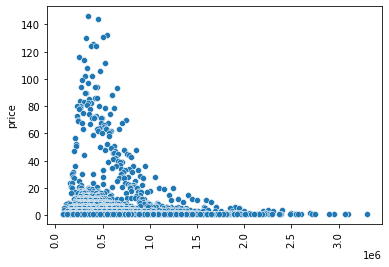

Graph for bedrooms: Total = 11


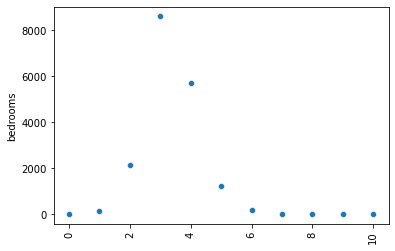

Graph for bathrooms: Total = 23


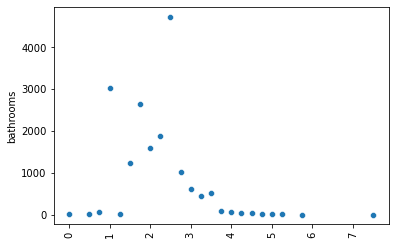

Graph for sqft_living: Total = 763


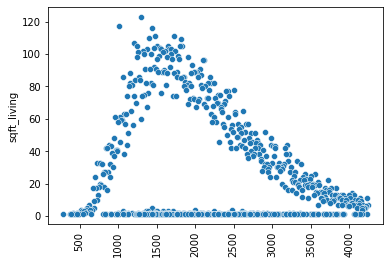

Graph for sqft_lot: Total = 9028


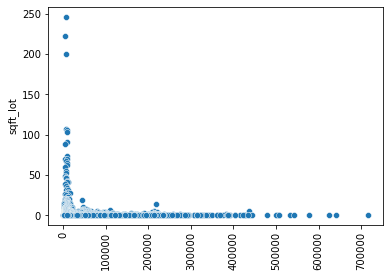

Graph for floors: Total = 6


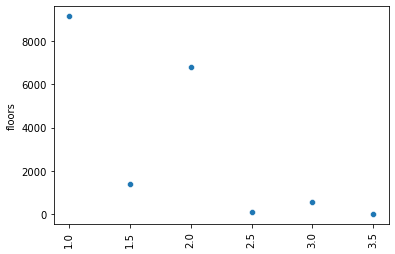

Graph for waterfront: Total = 2


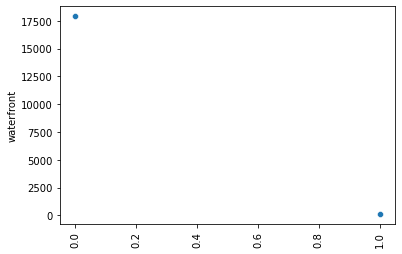

Graph for view: Total = 5


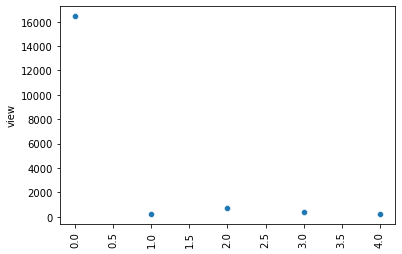

Graph for condition: Total = 5


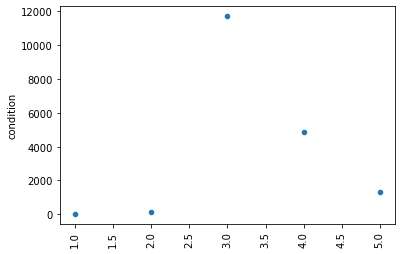

Graph for grade: Total = 11


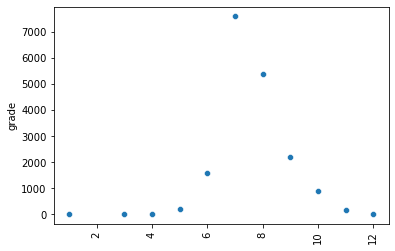

Graph for sqft_above: Total = 751


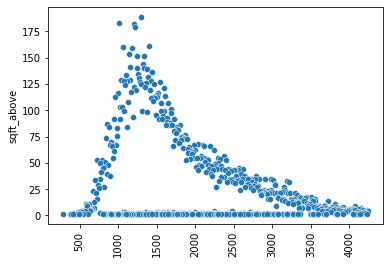

Graph for sqft_basement: Total = 253


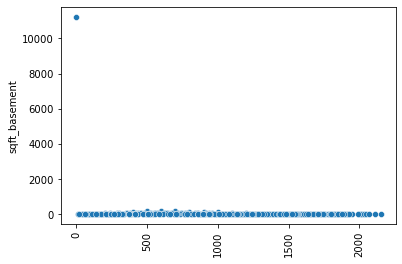

Graph for zipcode: Total = 70


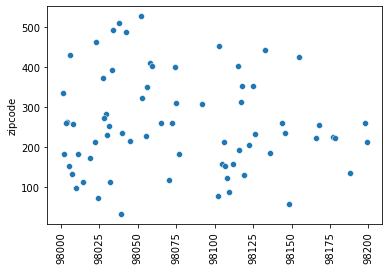

Graph for sqft_living15: Total = 660


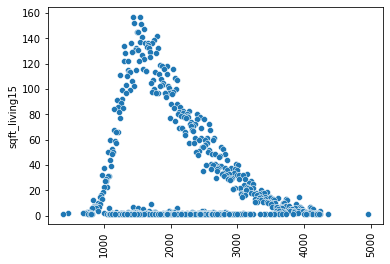

Graph for sqft_lot15: Total = 8038


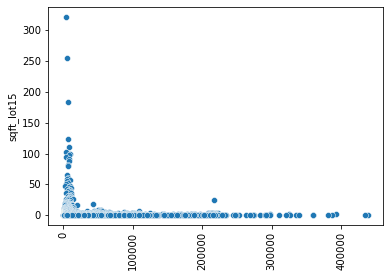

Graph for house_age: Total = 117


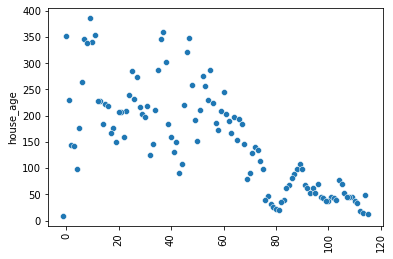

In [107]:
def plot_scatterplots2():
    for i in cols_to_plot2.columns:
        cat_num = cols_to_plot2[i].value_counts()
        print(f'Graph for {i}: Total = {len(cat_num)}')
        sns.scatterplot(x=cat_num.index, y=cat_num)
        plt.xticks(rotation=90)
        plt.show()
        
        
plot_scatterplots2()

# Modelling

In [160]:
X_outliers = df_outliers.drop(['price', 'sqft_living_bin', 'sqft_above_bin', 'house_age_bin'], axis='columns')
y_outliers = df_outliers['price']
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size= 0.2, random_state = 42)

## LR Drop Outliers Model

In [161]:
pipeline_LR.fit(X_train_outliers,y_train_outliers)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [162]:
df_LR_outliers = Eva_matrix(pipeline_LR, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "Drop Outliers LR")
df_LR_outliers

,Train Drop Outliers LR,Test Drop Outliers LR
R2,0.62,0.60
MAE,122340.26,120004.95
MSE,31077127929.69,30573461998.61
RMSE,176287.06,174852.69


## KNN Drop Outliers Model

In [163]:
pipeline_KNN.fit(X_train_outliers,y_train_outliers)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [164]:
df_KNN_outliers = Eva_matrix(pipeline_KNN, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "Drop Outliers KNN")
df_KNN_outliers

,Train Drop Outliers KNN,Test Drop Outliers KNN
R2,0.76,0.62
MAE,92452.11,110885.12
MSE,19456789985.63,29560140270.97
RMSE,139487.60,171930.63


## SV Regression Drop Outliers Model

In [165]:
pipeline_SVM.fit(X_train_outliers,y_train_outliers)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [166]:
df_SVM_outliers = Eva_matrix(pipeline_SVM, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "Drop Outliers SVM")
df_SVM_outliers

,Train Drop Outliers SVM,Test Drop Outliers SVM
R2,-0.05,-0.05
MAE,194213.15,190123.40
MSE,86095589364.11,81421783161.36
RMSE,293420.50,285345.02


## Decision Tree Regression Drop Outliers Model

In [167]:
pipeline_DT.fit(X_train_outliers,y_train_outliers)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [168]:
df_DT_outliers = Eva_matrix(pipeline_DT, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "Drop Outliers XGB")
df_DT_outliers

,Train Drop Outliers XGB,Test Drop Outliers XGB
R2,1.00,0.54
MAE,144.06,112320.44
MSE,8362980.00,35757815124.52
RMSE,2891.88,189097.37


## Random Forest Drop Outliers Model

In [169]:
pipeline_RF.fit(X_train_outliers,y_train_outliers)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'zipcode',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'house_age']),
                                                 ('categorical',
                                                  Pipeline(steps=

In [170]:
df_RF_outliers = Eva_matrix(pipeline_RF, X_train_outliers, y_train_outliers ,X_test_outliers, y_test_outliers, "Drop Outliers RF")
df_RF_outliers

,Train Drop Outliers RF,Test Drop Outliers RF
R2,0.97,0.78
MAE,30420.93,78732.10
MSE,2457125480.16,17032278933.19
RMSE,49569.40,130507.77


# Fine Tuning

## KNN Fine Tuning

In [171]:
param_KNNb = {
    'algo__weights': ['distance'],
 'algo__p': [20],
 'algo__n_neighbors': [100],
 'algo__leaf_size': [20]}


In [172]:
KNN_GS_outliers = GridSearchCV(pipeline_KNN, param_KNNb, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [173]:
KNN_GS_outliers.fit(X_train_outliers, y_train_outliers)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [174]:
KNN_GS_outliers.best_params_

{'algo__leaf_size': 20,
 'algo__n_neighbors': 100,
 'algo__p': 20,
 'algo__weights': 'distance'}

In [175]:
KNN_T_outliers = KNN_GS_outliers.best_estimator_

In [176]:
df_KNN_T_outliers = Eva_matrix(KNN_T_outliers, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "KNN Tuned")
df_KNN_T_outliers

,Train KNN Tuned,Test KNN Tuned
R2,1.00,0.54
MAE,144.06,120452.88
MSE,8362980.00,35587519171.40
RMSE,2891.88,188646.55


## DT Fine Tuning

In [177]:
#because our aim is to make it not overfit (decrease the training score and/or increase the test score), 
#we try to increase the value of max_depth, samples_leaf, sample_split, and n_estimator, and also decrease value max_features

param_DTb = {'algo__min_samples_split': [50],
 'algo__min_samples_leaf': [21],
 'algo__max_features': [0.5],
 'algo__max_depth': [50]}

In [178]:
DT_GS_outliers = GridSearchCV(pipeline_DT, param_DTb, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [179]:
DT_GS_outliers.fit(X_train_outliers, y_train_outliers)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [180]:
DT_GS_outliers.best_params_

{'algo__max_depth': 50,
 'algo__max_features': 0.5,
 'algo__min_samples_leaf': 21,
 'algo__min_samples_split': 50}

In [181]:
DT_T_outliers = DT_GS_outliers.best_estimator_

In [182]:
df_DT_T_outliers = Eva_matrix(DT_T_outliers, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "DT Tuned")
df_DT_T_outliers

,Train DT Tuned,Test DT Tuned
R2,0.70,0.61
MAE,99911.80,108877.05
MSE,24822934114.29,29886586076.31
RMSE,157552.96,172877.37


## Random Forest Fine Tuning

In [183]:
#because our aim is to make it not overfit (decrease the training score and/or increase the test score), 
#we try to increase the value of max_depth, samples_leaf, sample_split, and n_estimator, and also decrease value max_features

param_RFb = {
    'algo__max_depth': [3000],
 'algo__max_features': [0.9],
 'algo__min_samples_leaf': [15],
 'algo__n_estimators': [3300],
     'algo__min_samples_split': [17],
}

In [184]:
RF_GS_outliers = GridSearchCV(pipeline_RF, param_RFb, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)

In [185]:
RF_GS_outliers.fit(X_train_outliers, y_train_outliers)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors

In [186]:
RF_GS_outliers.best_params_

{'algo__max_depth': 3000,
 'algo__max_features': 0.9,
 'algo__min_samples_leaf': 15,
 'algo__min_samples_split': 17,
 'algo__n_estimators': 3300}

In [187]:
RF_T_outliers = RF_GS_outliers.best_estimator_

In [188]:
df_RF_T_outliers = Eva_matrix(RF_T_outliers, X_train_outliers, y_train_outliers, X_test_outliers, y_test_outliers, "RF Tuned")
df_RF_T_outliers

,Train RF Tuned,Test RF Tuned
R2,0.80,0.73
MAE,80525.63,88638.00
MSE,16609991111.51,20676766123.04
RMSE,128879.75,143794.18


after long journey of dropping outliers, it turned out that the R2 score is not much different than before (even worse).
but actually the score is not that bad, even arguably accepted to use.

however, if we want to try improve it again, we might try to do feature engineering and/or feature selection.